In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import anndata
import scipy
import scanpy as sc

# extract pcs sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
npcs = 14

# File Paths

### Input files path

In [3]:
gene_expression_vs_coord_data_file = "../Data/others/Melanoma/ST_mel1_rep2_counts.tsv"
mclust_scribbles_file_csv = "../Data/others/Melanoma/mclust_result.csv"
manual_scribble_file_csv = "../Data/others/Melanoma/manual_scribble.csv"
mclust_backbone_file_csv = "../Data/others/Melanoma/mclust_backbone.csv"
manual_annotation_file_csv = "../Data/others/Melanoma/manual_annotations.csv"

### Output files path

In [4]:
map_pixel_to_grid_spot_file_path = "../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Jsons/map_pixel_to_grid_spot.json"
background_path = "../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Npys/backgrounds.npy"
foreground_path = "../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Npys/foregrounds.npy"
pixel_barcode_file_path = "../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Npys/pixel_barcode.npy"
pca_file_path = f"../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Npys/mapped_{npcs}.npy"
mclust_scribbles_file = "../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Scribble/mclust_scribble.npy"
manual_scribbles_file = "../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Scribble/manual_scribble_1.npy"
mclust_backbone_file = "../Algorithms/Unsupervised_Segmentation/Approaches/With_Scribbles/Local_Data/others/Melanoma/Scribble/mclust_backbone_scribble.npy"

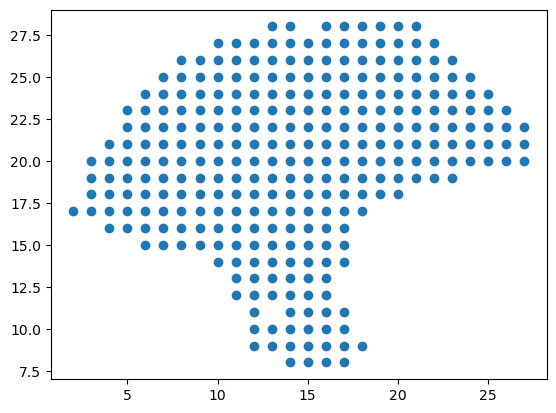

In [5]:
# Read the data tsv file
data = pd.read_csv(gene_expression_vs_coord_data_file, sep='\t')

x_pixels = []
y_pixels = []
texts = []
for spot in data.columns:
    if spot != 'gene':
        y_pixels.append(int(spot.split('x')[0])+1)
        x_pixels.append(int(spot.split('x')[1])-1)
        texts.append(spot)
plt.scatter(x_pixels, y_pixels)

# for i in range(len(x_pixels)):
#     plt.scatter(x_pixels[i], y_pixels[i],s=1)
#     plt.text(x_pixels[i], y_pixels[i], texts[i], fontsize=4)

In [6]:
data.set_index('gene', inplace=True)
data = data.transpose()
data.head()

gene,PSME2 ENSG00000100911,CUEDC1 ENSG00000180891,RPLP1 ENSG00000137818,TM9SF3 ENSG00000077147,DEF8 ENSG00000140995,RPL37A ENSG00000197756,NELL1 ENSG00000165973,MFGE8 ENSG00000140545,AIP ENSG00000110711,TSC22D3 ENSG00000157514,...,TREM1 ENSG00000124731,C2CD4A ENSG00000198535,TAF1L ENSG00000122728,PEBP4 ENSG00000134020,BCL2L15 ENSG00000188761,MYBPC2 ENSG00000086967,RHOD ENSG00000173156,PPEF1 ENSG00000086717,CKMT2 ENSG00000131730,PGM5P2 ENSG00000277778
7x15,2,0,21,0,0,28,2,2,1,0,...,0,0,0,0,0,0,0,0,0,0
7x16,0,0,13,0,0,13,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
7x17,0,0,13,0,0,15,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
7x18,0,1,18,0,1,17,2,3,1,0,...,0,0,0,0,0,0,0,0,0,0
8x13,0,0,10,0,0,3,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df = pd.DataFrame({'axis_1': x_pixels, 'axis_2': y_pixels}, index=data.index)
df.head()
df.to_csv('../Data/others/Melanoma/coordinates.csv')

In [8]:
# create anndata object from pandas dataframe data
adata = anndata.AnnData(X = data)
adata.obsm['spatial'] = np.array([x_pixels, y_pixels]).T
adata.obs['array_row'] = x_pixels
adata.obs['array_col'] = y_pixels

# save the anndata object
adata.write('../Data/others/Melanoma/reading_h5/Melanoma_filtered_feature_bc_matrix.h5')
bdata = adata.copy()

/tmp/ipykernel_23591/1120857868.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X = data)


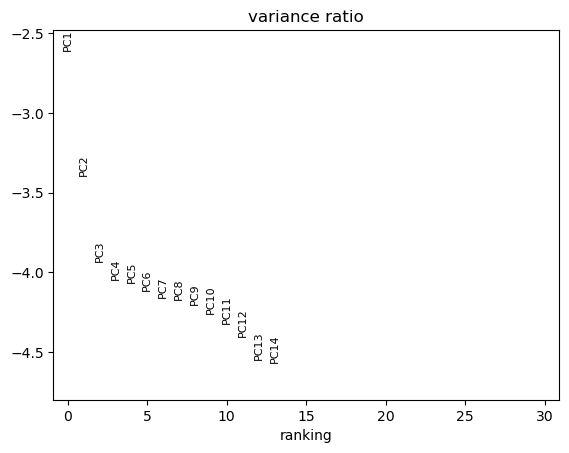

In [9]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

sc.pp.pca(adata,n_comps=npcs)
sc.pl.pca_variance_ratio(adata, log=True)

In [10]:
high_genes = [i for i in adata.var['highly_variable'].index if adata.var['highly_variable'][i]]

data = data[high_genes]
data.head()

gene,RPLP1 ENSG00000137818,NEURL1 ENSG00000107954,TMEM251 ENSG00000153485,LGALS3 ENSG00000131981,ERC2 ENSG00000187672,BNIP3 ENSG00000176171,WBSCR22 ENSG00000071462,NDUFB6 ENSG00000165264,DCN ENSG00000011465,MYO9B ENSG00000099331,...,SLC23A1 ENSG00000170482,CTD-2619J13.19 ENSG00000269473,LINC01503 ENSG00000233901,CTD-2118P12.1 ENSG00000259786,GRM8 ENSG00000179603,RP11-744K17.1 ENSG00000261020,RP11-1250I15.3 ENSG00000271771,RP11-700H6.1 ENSG00000247011,GLI1 ENSG00000111087,MCF2L2 ENSG00000053524
7x15,21,0,0,6,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7x16,13,0,0,6,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7x17,13,0,0,2,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
7x18,18,0,0,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8x13,10,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# X = data.drop('gene', axis=1).values.T
X = StandardScaler().fit_transform(data)
pca = PCA(n_components=npcs)
X_pca = pca.fit_transform(X)

mapped_14 = np.zeros((max(y_pixels)+1, max(x_pixels)+1, npcs))
for i in range(len(x_pixels)):
    mapped_14[y_pixels[i], x_pixels[i]] = X_pca[i]

np.save(pca_file_path, mapped_14)

In [12]:
def make_grid_idx(x_pixels,y_pixels):
    grid_idx = np.zeros((max(y_pixels)+1,max(x_pixels)+1)) - 1
    for i in range(len(x_pixels)):
        grid_idx[y_pixels[i],x_pixels[i]] = 1
    return grid_idx

def get_pixel_to_grid_spot_map(grid_pixel_coor, grid_idx):
    n = grid_pixel_coor.shape[0]
    m = grid_pixel_coor.shape[1]
    map_pixel_to_grid_spot = {}
    for i in range(n):
        for j in range(m):
            if grid_idx[i, j] != -1:
                map_from = f'({i}, {j})'
                map_to = (i, j)
                map_pixel_to_grid_spot[map_from] = map_to
    return map_pixel_to_grid_spot


(29, 28)


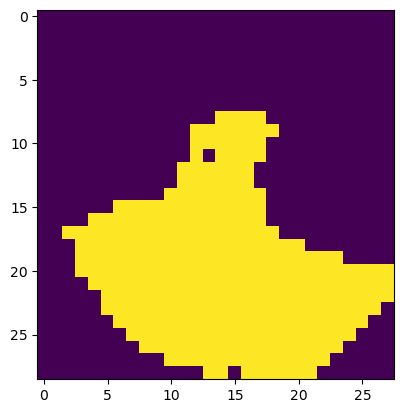

In [13]:
grid_idx = make_grid_idx(x_pixels,y_pixels)
print(grid_idx.shape)
map_pixel_to_grid_spot = get_pixel_to_grid_spot_map(grid_idx, grid_idx)
plt.imshow(grid_idx)

In [14]:
with open(map_pixel_to_grid_spot_file_path, "w") as outfile:
    json.dump(map_pixel_to_grid_spot, outfile)

In [15]:
backgrounds = np.argwhere(grid_idx == -1)
foregrounds = np.argwhere(grid_idx == 1)

In [16]:
np.save(background_path, backgrounds)
np.save(foreground_path, foregrounds)

In [17]:
def make_pixel_barcode(grid_idx,x_pixels,y_pixels):
    mx_row,mx_col = grid_idx.shape

    pixel_barcode = np.empty([mx_row + 1, mx_col + 1], dtype='<U100')

    for i in range(len(x_pixels)):
        pixel_barcode[y_pixels[i], x_pixels[i]] = str(y_pixels[i]-1) + "x" + str(x_pixels[i]+1)
    return pixel_barcode


In [18]:
pixel_barcode = make_pixel_barcode(grid_idx,x_pixels,y_pixels)
np.save(pixel_barcode_file_path, pixel_barcode)

In [19]:
new_scribble_spot = np.full_like(grid_idx, 255)
new_backbone_spot = np.full_like(grid_idx, 255)

df_mclust_scribble = pd.read_csv(mclust_scribbles_file_csv)
df_mclust_scribble.set_index("Unnamed: 0",inplace=True)
df_mclust_scribble.head()

,cluster.init
Unnamed: 0,
7x15,0
7x16,1
7x17,1
7x18,1
8x13,1


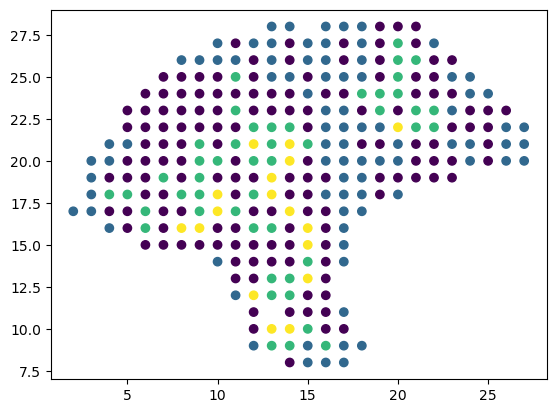

In [20]:
x_pixels = []
y_pixels = []
labels = []
for i in range(df_mclust_scribble.shape[0]):
    spot = df_mclust_scribble.index[i]
    x_pixels.append(int(spot.split("x")[1])-1)
    y_pixels.append(int(spot.split("x")[0])+1)
    labels.append(df_mclust_scribble.iloc[i,0])

plt.scatter(x_pixels, y_pixels, c=labels)

In [21]:
new_scribble_spot[y_pixels,x_pixels] = labels
np.save(mclust_scribbles_file,new_scribble_spot)

In [22]:
new_scribble_spot = np.full_like(grid_idx, 255)

df_manual_scribble = pd.read_csv(manual_scribble_file_csv)
df_manual_scribble.set_index("Unnamed: 0",inplace=True)

df_mclust_backbone = pd.read_csv(mclust_backbone_file_csv)
df_mclust_backbone.set_index("Unnamed: 0",inplace=True)

In [23]:
df_manual_scribble.head()

,cluster.init
Unnamed: 0,
7x15,NaN
7x16,NaN
7x17,NaN
7x18,NaN
8x13,NaN


In [24]:
df_mclust_backbone.head()

,cluster.init
Unnamed: 0,
7x15,NaN
7x16,1.0
7x17,1.0
7x18,1.0
8x13,NaN


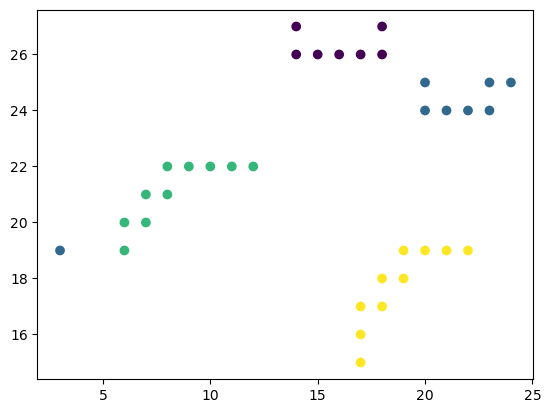

In [25]:
x_pixels = []
y_pixels = []
labels_scribble = []
for i in range(df_manual_scribble.shape[0]):
    spot = df_manual_scribble.index[i]
    if not math.isnan(df_manual_scribble.iloc[i,0]):
        x_pixels.append(int(spot.split("x")[1])-1)
        y_pixels.append(int(spot.split("x")[0])+1)
        labels_scribble.append(df_manual_scribble.iloc[i,0]+1)
    # else :
    #     y_pixels.append(int(spot.split("x")[1]))
    #     x_pixels.append(int(spot.split("x")[0]))
    #     labels_scribble.append(0)

plt.scatter(x_pixels,y_pixels,c=labels_scribble)

In [26]:
new_scribble_spot[y_pixels,x_pixels] = labels_scribble
np.save(manual_scribbles_file,new_scribble_spot)

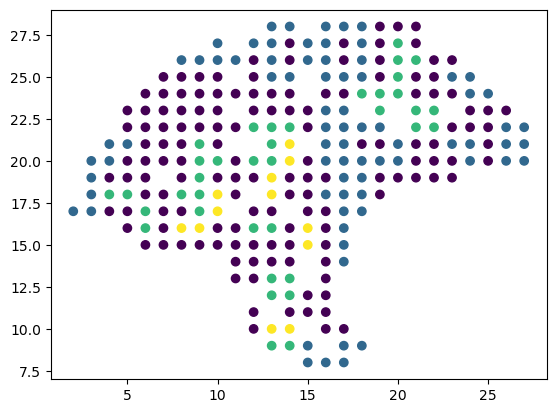

In [27]:
x_pixels = []
y_pixels = []
labels_backbone = []
for i in range(df_mclust_backbone.shape[0]):
    spot = df_mclust_backbone.index[i]
    if not math.isnan(df_mclust_backbone.iloc[i,0]):
        x_pixels.append(int(spot.split("x")[1])-1)
        y_pixels.append(int(spot.split("x")[0])+1)
        labels_backbone.append(df_mclust_backbone.iloc[i,0]+1)
    # else :
    #     x_pixels.append(int(spot.split("x")[1])-1)
    #     y_pixels.append(int(spot.split("x")[0])+1)
    #     labels_backbone.append(0)
        
plt.scatter(x_pixels,y_pixels,c=labels_backbone)

In [28]:
new_backbone_spot[y_pixels,x_pixels] = labels_backbone
np.save(mclust_backbone_file,new_backbone_spot)

In [29]:
print(max(y_pixels),max(x_pixels))

28 27


In [30]:
manual_annotation = pd.read_csv(manual_annotation_file_csv)
manual_annotation.set_index("Unnamed: 0",inplace=True)

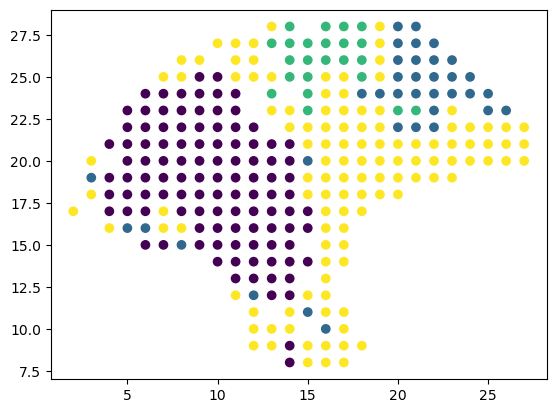

In [31]:

x_pixels = []
y_pixels = []
clusters = []
for spot in manual_annotation.index.values:
    if spot != 'gene':
        y_pixels.append(int(spot.split('x')[0])+1)
        x_pixels.append(int(spot.split('x')[1])-1)
        if manual_annotation.loc[spot,'label'] != None:
            clusters.append(manual_annotation.loc[spot,'label'])
        else:
            clusters.append(255)
plt.scatter(x_pixels, y_pixels,c=clusters)